In [64]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

Download dataset from Yahoo Finance

In [ ]:
# Download S&P 500 index data from Yahoo Finance
sp500_data = yf.download("^GSPC", start="2015-01-01", end="2025-12-01")
sp500_data.to_csv("sp500_index_data.csv")

# Download Gold data from Yahoo Finance
gold_data = yf.download("GC=F", start="2015-01-01", end="2025-12-01")
gold_data.to_csv("gold_data.csv")

# Download Bitcoin data from Yahoo Finance
bitcoin_data = yf.download("BTC-USD", start="2015-01-01", end="2025-12-01")
bitcoin_data.to_csv("bitcoin_data.csv")

# Download US Dollar index data from Yahoo Finance
usd_index_data = yf.download("DX-Y.NYB", start="2015-01-01", end="2025-12-01")
usd_index_data.to_csv("usd_index_data.csv")



Create a function to clean dataset

In [8]:
def wrangling(filepath):
    df = pd.read_csv(filepath)
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.strip()
    
    # Force first column to be date column
    date_col = df.columns[0]
    
    # Remove rows where date column is not a real date (e.g. "Ticker")
    df = df[df[date_col].astype(str).str.contains(r"\d", regex=True)]
    
    # Convert to datetime safely
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    
    # Drop rows where conversion failed
    df = df.dropna(subset=[date_col])
    
    # Set index
    df = df.set_index(date_col)
    
    # Sort ascending
    df = df.sort_index()
    
    # Drop duplicate index
    df = df[~df.index.duplicated(keep="first")]
    
    # Convert remaining columns to numeric
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    return df

    



In [9]:
# Wrangle all datasets
sp500 = wrangling("sp500_index_data.csv")
gold = wrangling("gold_data.csv")
bitcoin = wrangling("bitcoin_data.csv")
usdx = wrangling("usd_index_data.csv")
vix = wrangling("VIXCLS.csv")
cpi = wrangling("CPIAUCSL.csv")



Time Alignment and Merging


In [10]:
gold.head()

,close,high,low,open,volume
price,,,,,
2015-01-02,1186.000000,1194.500000,1169.500000,1184.000000,138
2015-01-05,1203.900024,1206.900024,1180.099976,1180.300049,470
2015-01-06,1219.300049,1220.000000,1203.500000,1203.500000,97
2015-01-07,1210.599976,1219.199951,1210.599976,1219.199951,29
2015-01-08,1208.400024,1215.699951,1206.300049,1207.000000,92


In [11]:
# Find global date range

print(sp500.index.min(), sp500.index.max())
print(gold.index.min(), gold.index.max())        
print(bitcoin.index.min(), bitcoin.index.max())
print(usdx.index.min(), usdx.index.max())
print(vix.index.min(), vix.index.max())
print(cpi.index.min(), cpi.index.max())

all_mins = [
    sp500.index.min(), gold.index.min(), 
    bitcoin.index.min(), usdx.index.min(), 
    vix.index.min(), cpi.index.min()
    ]

all_max = [
    sp500.index.max(), gold.index.max(),
    bitcoin.index.max(), usdx.index.max(),
    vix.index.max(), cpi.index.max()
    ]

start_date = min(all_mins)
end_date = max(all_max)

print(start_date, end_date)


2015-01-02 00:00:00 2025-11-28 00:00:00
2015-01-02 00:00:00 2025-11-28 00:00:00
2015-01-01 00:00:00 2025-11-30 00:00:00
2015-01-02 00:00:00 2025-11-28 00:00:00
2015-01-02 00:00:00 2025-12-01 00:00:00
2015-01-01 00:00:00 2025-12-01 00:00:00
2015-01-01 00:00:00 2025-12-01 00:00:00


In [12]:
# Create master daily index
master_index = pd.date_range(start = start_date, end = end_date, freq='D')

print(master_index[:5])
print(master_index[-5:])

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05'],
              dtype='datetime64[us]', freq='D')
DatetimeIndex(['2025-11-27', '2025-11-28', '2025-11-29', '2025-11-30',
               '2025-12-01'],
              dtype='datetime64[us]', freq='D')


By reindexing NAN appears on SP500, GOLD, DXY, VIX datasets that trade only on business days.
Also on CPI dataset that trades monthly.
BTC is unaffected because it trades daily.

In [13]:
# Reindex datedframes to master index
sp500 = sp500.reindex(master_index)
gold = gold.reindex(master_index)
bitcoin = bitcoin.reindex(master_index)
usdx = usdx.reindex(master_index)
vix = vix.reindex(master_index)
cpi = cpi.reindex(master_index)


In [14]:
#Forward fill the missing values
sp500 = sp500.ffill()
gold = gold.ffill()
usdx = usdx.ffill()
vix = vix.ffill()
cpi = cpi.ffill()



Change column header and merger dataset


In [15]:
# Rename columns for clarity
sp500.columns = [f"sp500_{col}" for col in sp500.columns]
gold.columns = [f"gold_{col}" for col in gold.columns]      
bitcoin.columns = [f"bitcoin_{col}" for col in bitcoin.columns]
usdx.columns = [f"usdx_{col}" for col in usdx.columns]

# Merge all datasets into a single DataFrame
master_df = pd.concat([sp500, gold, bitcoin, usdx, vix, cpi], axis=1)


In [16]:
master_df.head()

,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume,gold_close,gold_high,gold_low,gold_open,gold_volume,...,bitcoin_low,bitcoin_open,bitcoin_volume,usdx_close,usdx_high,usdx_low,usdx_open,usdx_volume,vixcls,cpiaucsl
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,314.002991,320.434998,8036550.0,NaN,NaN,NaN,NaN,NaN,NaN,234.747
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,313.565002,314.079010,7860650.0,91.080002,91.160004,90.330002,90.360001,0.0,17.79,234.747
2015-01-03,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,281.082001,314.846008,33054400.0,91.080002,91.160004,90.330002,90.360001,0.0,17.79,234.747
2015-01-04,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,257.612000,281.145996,55629100.0,91.080002,91.160004,90.330002,90.360001,0.0,17.79,234.747
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3.799120e+09,1203.900024,1206.900024,1180.099976,1180.300049,470.0,...,265.084015,265.084015,43962800.0,91.379997,91.779999,91.129997,91.129997,0.0,19.92,234.747


In [17]:
 #Compute daily returns for sp500, gold, bitcoin, and usdx for closing prices
close_col = ["sp500_close", "gold_close", "bitcoin_close", "usdx_close"]

for col in close_col:
    master_df[col + "_return"] = master_df[col].pct_change()

extra_cols = ["vixcls", "cpiaucsl"]

for col in extra_cols:
    master_df[col + "_change"] = master_df[col].pct_change()



Handle Missing Values

In [18]:
# Drop first row that has all na vailues
master_df = master_df.drop(master_df.index[0])
master_df.head()

,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume,gold_close,gold_high,gold_low,gold_open,gold_volume,...,usdx_open,usdx_volume,vixcls,cpiaucsl,sp500_close_return,gold_close_return,bitcoin_close_return,usdx_close_return,vixcls_change,cpiaucsl_change
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,90.360001,0.0,17.79,234.747,NaN,NaN,0.002492,NaN,NaN,0.0
2015-01-03,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,90.360001,0.0,17.79,234.747,0.000000,0.000000,-0.107767,0.000000,0.000000,0.0
2015-01-04,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,90.360001,0.0,17.79,234.747,0.000000,0.000000,-0.060079,0.000000,0.000000,0.0
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3.799120e+09,1203.900024,1206.900024,1180.099976,1180.300049,470.0,...,91.129997,0.0,19.92,234.747,-0.018278,0.015093,0.038907,0.003294,0.119730,0.0
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4.460110e+09,1219.300049,1220.000000,1203.500000,1203.500000,97.0,...,91.379997,0.0,21.12,234.747,-0.008893,0.012792,0.042682,0.001313,0.060241,0.0


In [19]:
# Drop rows with any na values in key columns
master_df = master_df.dropna(subset = ["bitcoin_close_return"])


EDA and Visual Storytelling

In [20]:
# Normalize prices to start at 100. 
# This is so price would be a steady increase from 100, to see if stable or volatile

sp500_norm = master_df["sp500_close"] / master_df["sp500_close"].iloc[0] * 100
gold_norm = master_df["gold_close"] / master_df["gold_close"].iloc[0] * 100
bitcoin_norm = master_df["bitcoin_close"] / master_df["bitcoin_close"].iloc[0] * 100
usdx_norm = master_df["usdx_close"] / master_df["usdx_close"].iloc[0] * 100


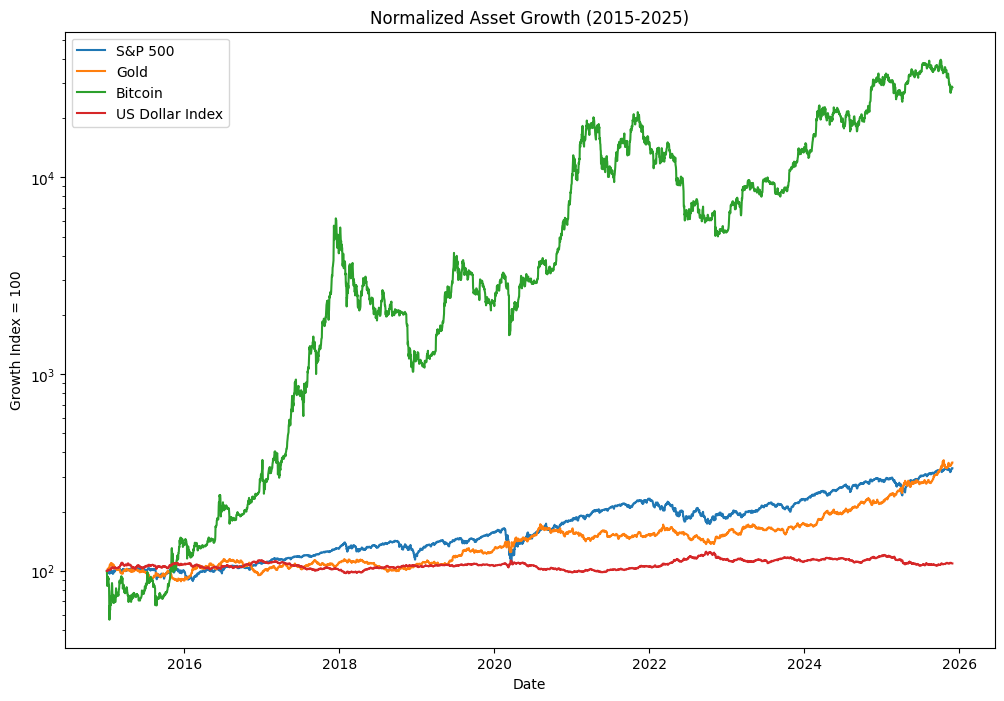

In [76]:
# Plot normalized prices to view growth over time
# Because Bitcoin's growth magnitude is significantly larger than
# traditional assets, a logarithmic scale was used to fairly compare relative growth rates across assets.

fig = plt.figure(figsize=(12, 8))
plt.plot(sp500_norm, label = "S&P 500")
plt.plot(gold_norm, label =  "Gold")
plt.plot(bitcoin_norm, label = "Bitcoin")
plt.plot(usdx_norm, label = "US Dollar Index")

plt.title("Normalized Asset Growth (2015-2025)")
plt.ylabel("Growth Index = 100")
plt.xlabel("Date")
plt.yscale("log")

plt.legend()
plt.show()


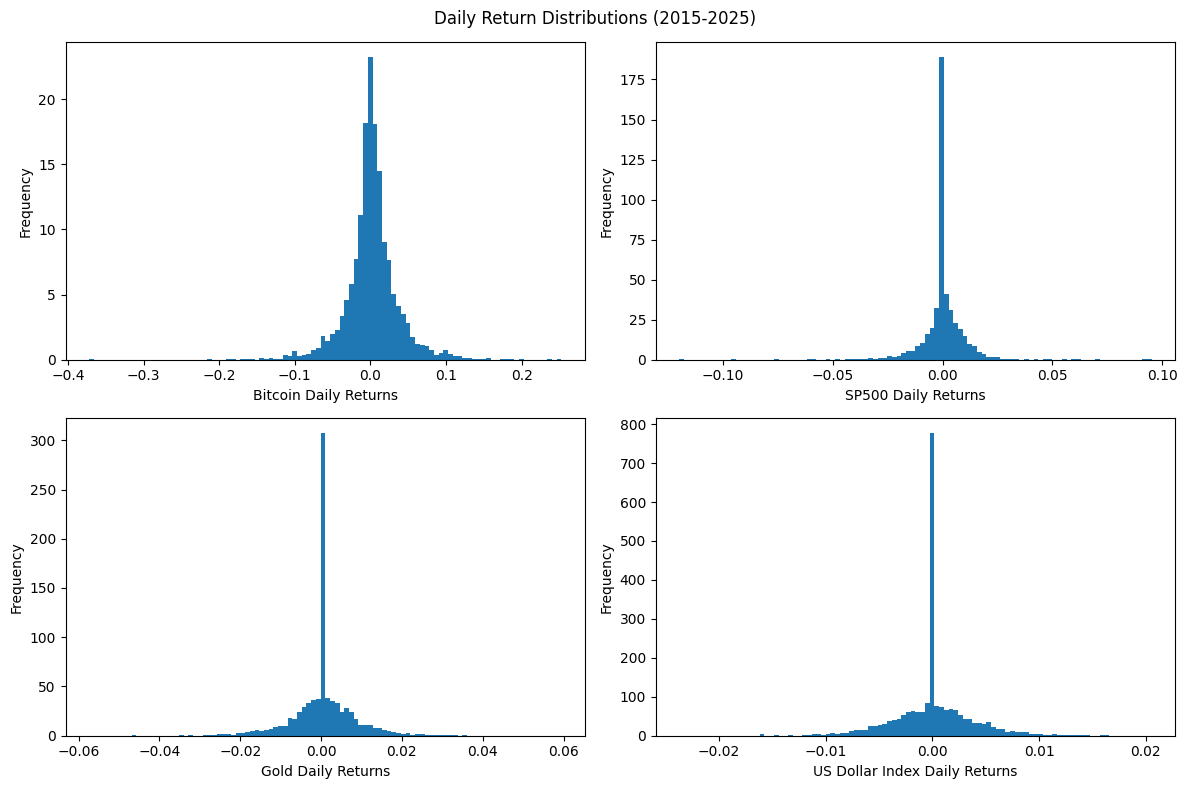

In [41]:
# Plot histograms of daily return distributions for each asset

fig = plt.figure(figsize = (12, 8))

plt.subplot(2,2,1)
plt.hist(master_df["bitcoin_close_return"],
         bins = 100, density=True, label = ["Bitcoin"])
plt.xlabel("Bitcoin Daily Returns")
plt.ylabel("Frequency")

plt.subplot(2,2,2)
plt.hist(master_df["sp500_close_return"],
         bins = 100, density=True, label = ["S&P500"])
plt.xlabel("SP500 Daily Returns")
plt.ylabel("Frequency")

plt.subplot(2,2,3)
plt.hist(master_df["gold_close_return"],
         bins = 100, density=True, label = ["Gold"])
plt.xlabel("Gold Daily Returns")
plt.ylabel("Frequency")

plt.subplot(2,2,4)
plt.hist(master_df["usdx_close_return"],
         bins = 100, density=True, label = ["US Dollar Index"])
plt.xlabel("US Dollar Index Daily Returns")
plt.ylabel("Frequency")

plt.suptitle("Daily Return Distributions (2015-2025)")

plt.tight_layout()
plt.show()



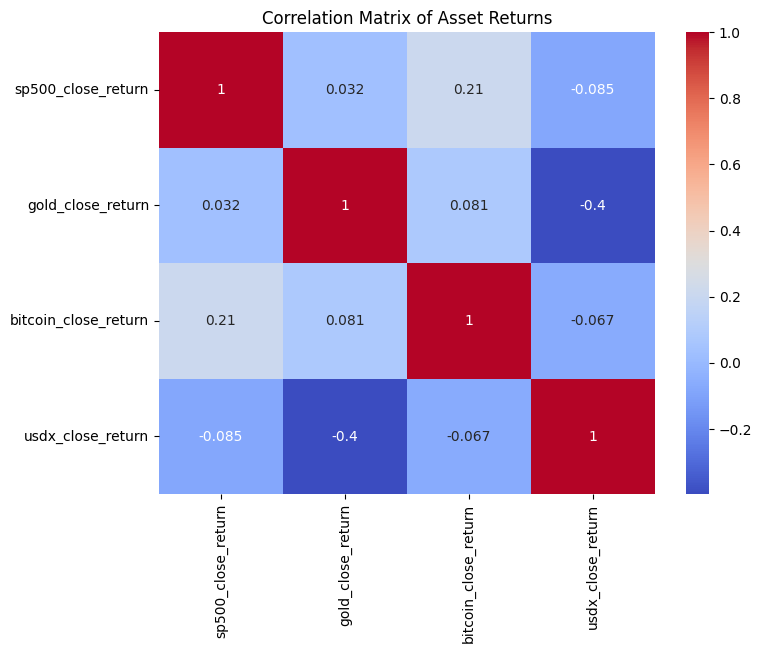

In [42]:
# Plot heatmap of correlations between asset returns

corr = master_df[[
    "sp500_close_return", "gold_close_return",
    "bitcoin_close_return", "usdx_close_return"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Asset Returns")
plt.show()

Drawdown Analysis (Crash Protection)

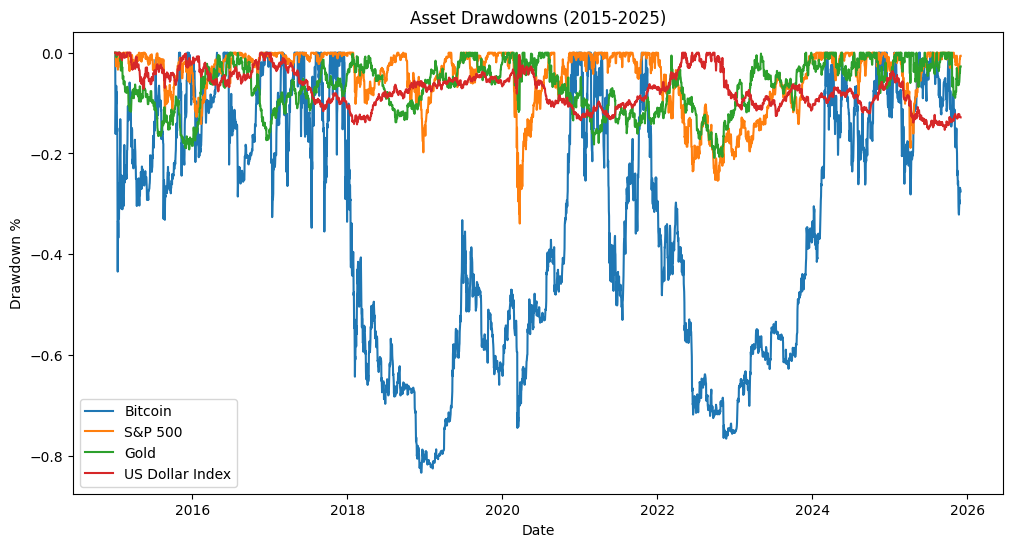

In [90]:
#  compute running peaks

bitcoin_peak = bitcoin_norm.cummax()
sp500_peak = sp500_norm.cummax()
gold_peak = gold_norm.cummax()
usdx_peak = usdx_norm.cummax()

#  compute drawdowns
bitcoin_drawdown = (bitcoin_norm - bitcoin_peak) / bitcoin_peak
sp500_drawdown = (sp500_norm - sp500_peak) / sp500_peak
gold_drawdown = (gold_norm - gold_peak) / gold_peak
usdx_drawdown = (usdx_norm - usdx_peak) / usdx_peak

# Plot drawdowns over time

plt.figure(figsize=(12, 6))
plt.plot(bitcoin_drawdown, label = "Bitcoin")
plt.plot(sp500_drawdown, label = "S&P 500")
plt.plot(gold_drawdown, label = "Gold")
plt.plot(usdx_drawdown, label = "US Dollar Index")

plt.title("Asset Drawdowns (2015-2025)")
plt.ylabel("Drawdown %")
plt.xlabel("Date")


plt.legend()
plt.show()

**CPI overlay(inflation Hedge Analysis)**

If an asset line:
*Stays above CPI line → beats inflation → real growth
*Tracks CPI closely → inflation hedge
*Stays below CPI → loses purchasing power

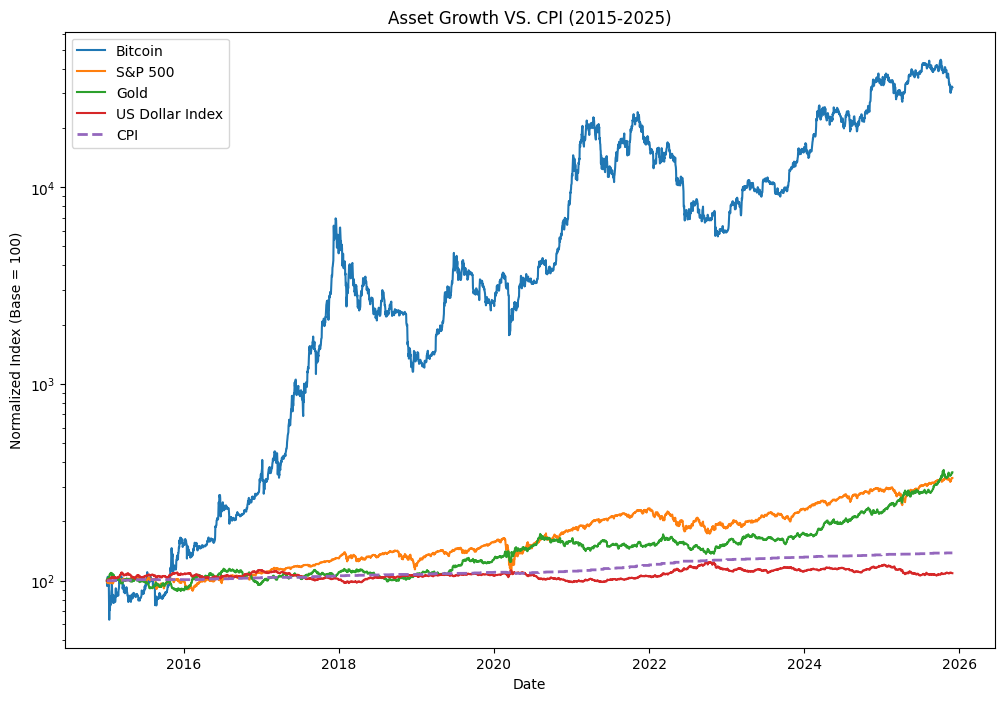

In [56]:
# Normalize cpi to start at 100
cpi_norm = master_df['cpiaucsl']/ master_df['cpiaucsl'].iloc[0] * 100

# plot cpi over assets

plt.figure(figsize=(12, 8))

plt.plot(bitcoin_norm, label = "Bitcoin")
plt.plot(sp500_norm, label = "S&P 500")
plt.plot(gold_norm, label = "Gold")
plt.plot(usdx_norm, label = "US Dollar Index")
plt.plot(cpi_norm, label = "CPI", linestyle='--', linewidth=2)

plt.title("Asset Growth VS. CPI (2015-2025)")
plt.ylabel("Normalized Index (Base = 100)")
plt.xlabel("Date")
plt.yscale("log")

plt.legend()
plt.show()



**Define a function to check specific crisis**

Events = Covid Crash(Feb 2020 - May 2020), 
        Inflation shock(Jan 2022 - Oct 2022), 
        Crypto crash(Nov 2021 - Dec 2022)

In [63]:
# Define the function for crisis

def plot_crisis(start, end, title):
    subset = master_df.loc[start:end]

    #Normalize prices to start at 100 for the crisis period
    sp = subset["sp500_close"] / subset["sp500_close"].iloc[0] * 100
    gd = subset["gold_close"] / subset["gold_close"].iloc[0] * 100
    bc = subset["bitcoin_close"] / subset["bitcoin_close"].iloc[0] * 100
    ux = subset["usdx_close"] / subset["usdx_close"].iloc[0] * 100

    # Plot normalized prices during crisis period
    plt.figure(figsize=(12, 8))
    plt.plot(bc, label = "Bitcoin")
    plt.plot(sp, label = "S&P 500")
    plt.plot(gd, label = "Gold")
    plt.plot(ux, label = "US Dollar Index")

    plt.title(title)
    plt.ylabel("Normalized Performance (Base = 100)")
    plt.xlabel("Date")

    plt.legend()
    plt.show()
    

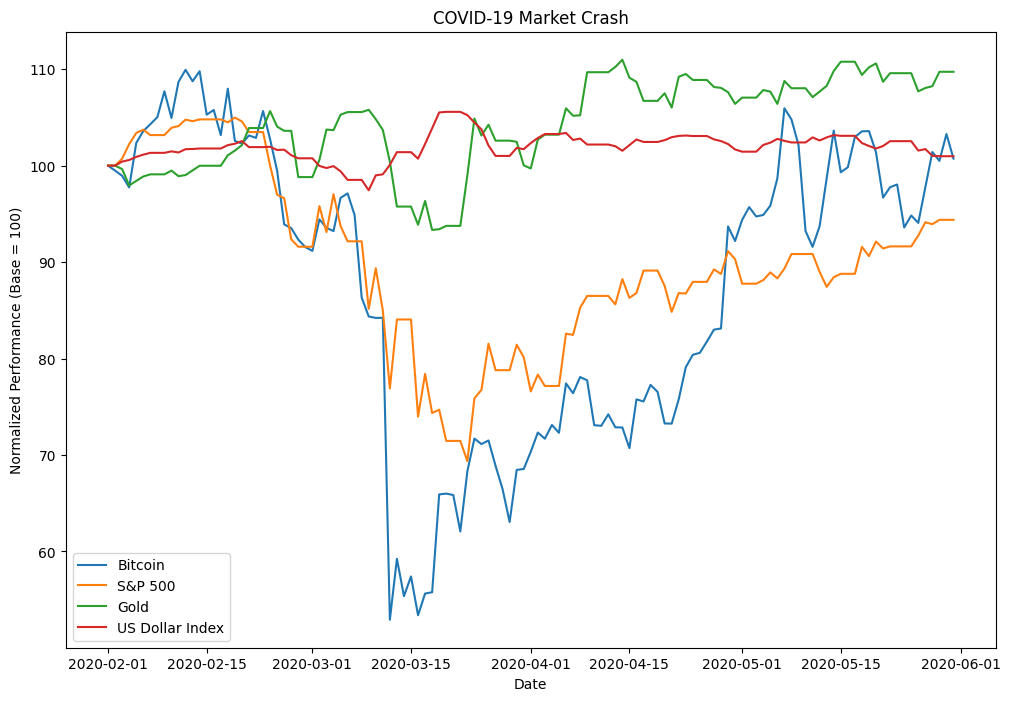

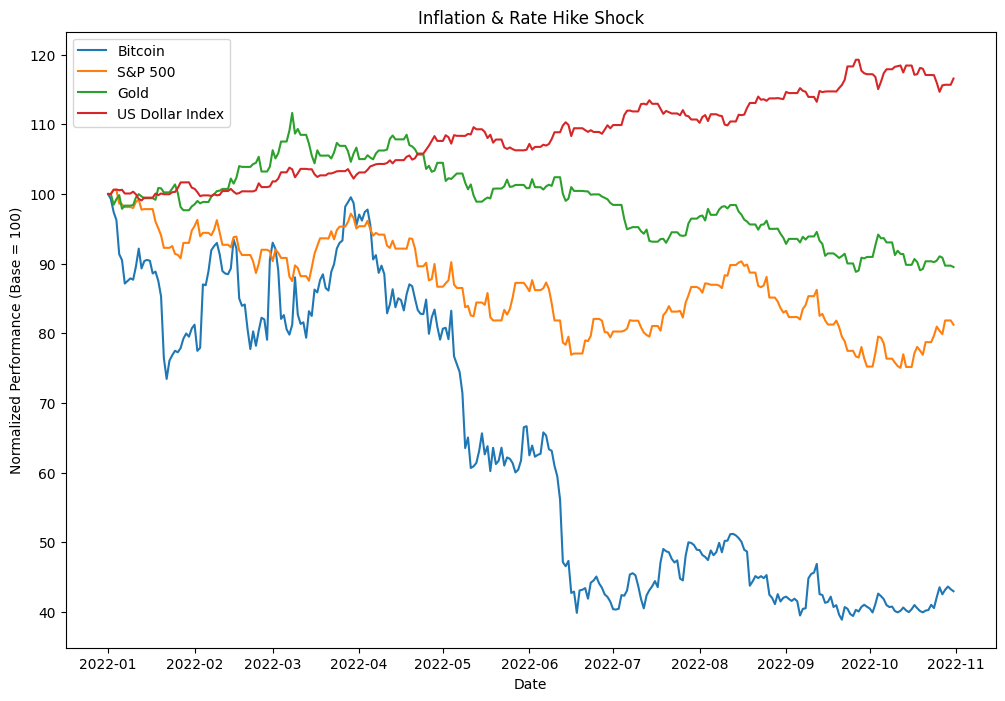

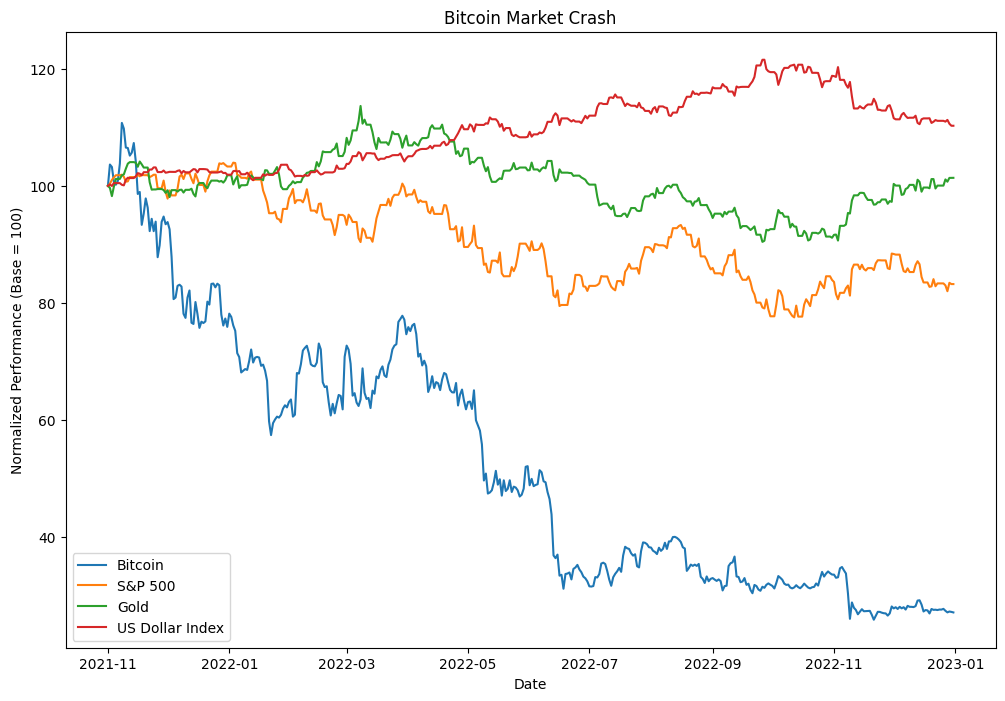

In [64]:
# Plot Crisis Periods
plot_crisis("2020-02-01", "2020-05-31", "COVID-19 Market Crash")
plot_crisis("2022-01-01", "2022-10-31", "Inflation & Rate Hike Shock")
plot_crisis("2021-11-01", "2022-12-31", "Bitcoin Market Crash")


**Safe Haven Evaluation**

In [78]:
# How bad can drawdowns get?

bitcoin_max_dd = bitcoin_drawdown.min()
sp500_max_dd = sp500_drawdown.min()
gold_max_dd = gold_drawdown.min()
usdx_max_dd = usdx_drawdown.min()

max_drawdowns = pd.DataFrame({
    "Asset": ["Bitcoin", "S&P 500", "Gold", "US Dollar Index"],
    "Max Drawdown": [bitcoin_max_dd, sp500_max_dd, gold_max_dd, usdx_max_dd]})

max_drawdowns["% Max Drawdown"] = max_drawdowns["Max Drawdown"].apply(lambda x: f"{x * 100:.2f}%")

print(max_drawdowns.sort_values(by="Max Drawdown").round(2))

             Asset  Max Drawdown % Max Drawdown
0          Bitcoin         -0.83        -83.40%
1          S&P 500         -0.34        -33.92%
2             Gold         -0.21        -20.87%
3  US Dollar Index         -0.15        -15.32%


**Performance During Market Crashes**

This is to measure average return during stock crash windows

# Positive average return during crash = safe haven
# Negative but small = partial hedge
# Large negative = risk asset

In [79]:
def average_crash_return(start, end, title):
    subset = master_df[start:end]
    
    return pd.Series({
        "Bitcoin" : subset["bitcoin_close_return"].mean(),
        "S&P 500" : subset["sp500_close_return"].mean(),
        "Gold" : subset["gold_close_return"].mean(),
        "US Dollar Index" : subset["usdx_close_return"].mean()
    })

# Average returns during crises

covid_crash = average_crash_return("2020-02-01", "2020-05-31", "COVID-19 Market Crash")
inflation_crash = average_crash_return("2022-01-01", "2022-10-31", "Inflation Shock")
crypto_crash = average_crash_return("2021-11-01", "2022-12-31", "Crypto Market Crash")

# Compute into a table

crash_returns = pd.DataFrame({
    "COVID-19 Crash": covid_crash,
    "Inflation Shock": inflation_crash,
    "Crypto Crash": crypto_crash
})

print(crash_returns.round(4) * 100)

                 COVID-19 Crash  Inflation Shock  Crypto Crash
Bitcoin                    0.16            -0.21         -0.25
S&P 500                   -0.01            -0.06         -0.04
Gold                       0.09            -0.03          0.01
US Dollar Index            0.01             0.05          0.02


***Correlation with VIX(Fear Index Test)***

The VIX measures market fear.

A true safe haven should:
# Have negative correlation with VIX
(When fear rises, the asset falls)

# A risk asset will:
Have positive correlation with VIX
(When fear rises, the asset rises or stays stable)

In [22]:
vix_corr = master_df[["bitcoin_close_return", "sp500_close_return",
                      "gold_close_return", "usdx_close_return", 
                      "vixcls_change"]].corr()["vixcls_change"]
print(vix_corr.sort_values(). round(2))



sp500_close_return     -0.72
bitcoin_close_return   -0.18
usdx_close_return       0.02
gold_close_return       0.03
vixcls_change           1.00
Name: vixcls_change, dtype: float64


**Sustainable Growth Evaluation**

In [27]:
# Compound Annual Growth Rates (CAGR) for each asset
n_years = (master_df.index[-1] - master_df.index[0]).days / 365.25
ending_values = {
    "Bitcoin": bitcoin_norm.iloc[-1],
    "S&P 500": sp500_norm.iloc[-1],
    "Gold": gold_norm.iloc[-1],
    "US Dollar Index": usdx_norm.iloc[-1]
}

cagr = {asset : (ending_values[asset] / 100)** (1/n_years) - 1 for asset, value in ending_values.items()}

cagr_df = pd.DataFrame.from_dict(cagr, orient = "index", columns = ["CAGR"])

print(cagr_df.round(4) * 100)


                  CAGR
Bitcoin          67.99
S&P 500          11.65
Gold             12.33
US Dollar Index   0.81


**Annualized Volatility**

Annualized Volatility = Standard Deviation(Daily) * square root(number of trading days; which is 252)

In [25]:
# Calculate volatility (standard deviation of daily returns annualized)

volatility = {
    "Bitcoin" : master_df["bitcoin_close_return"].std() * np.sqrt(252),
    "S&P 500" : master_df["sp500_close_return"].std() * np.sqrt(252),
    "Gold" : master_df["gold_close_return"].std() * np.sqrt(252),
    "US Dollar Index" : master_df["usdx_close_return"].std() * np.sqrt(252)
    }

volatility_df = pd.DataFrame.from_dict(volatility, orient="index", columns=["Annualized Volatility"])
print(volatility_df.round(4) * 100)


                 Annualized Volatility
Bitcoin                          56.06
S&P 500                          14.91
Gold                             12.67
US Dollar Index                   5.81


**Risk Adjustment Returns(Sharpe Ratio)**

# It measures the reward per unit of risk, with higher ratios indicating better risk adjusted performance

In [28]:
sharpe = {asset : cagr[asset] / volatility[asset] for asset in cagr.keys()}

sharpe_df = pd.DataFrame.from_dict(sharpe, orient="index", columns=["Sharpe Ratio"])
print(sharpe_df.round(4))

                 Sharpe Ratio
Bitcoin                1.2128
S&P 500                0.7814
Gold                   0.9733
US Dollar Index        0.1394


In [29]:
growth_table = pd.DataFrame({
    "CAGR": cagr,
    "Volatility": volatility,
    "Sharpe Ratio": sharpe
})

print(growth_table.round(4) * 100)

                  CAGR  Volatility  Sharpe Ratio
Bitcoin          67.99       56.06        121.28
S&P 500          11.65       14.91         78.14
Gold             12.33       12.67         97.33
US Dollar Index   0.81        5.81         13.94


Predictive Modelling

In [33]:
# Create next day return target columns for each asset
master_df["target_sp500"] = master_df["sp500_close_return"].shift(-1)

model_df = master_df.dropna(subset=["target_sp500"])

model_df[["sp500_close_return", "target_sp500"]].head()


,sp500_close_return,target_sp500
2015-01-02,NaN,0.000000
2015-01-03,0.000000,0.000000
2015-01-04,0.000000,-0.018278
2015-01-05,-0.018278,-0.008893
2015-01-06,-0.008893,0.011630


In [59]:
# Feature Selection

feature_cols = [
    "bitcoin_close_return",
    "sp500_close_return",
    "gold_close_return",
    "usdx_close_return",
    "vixcls_change",
    "cpiaucsl_change"
]

X = model_df[feature_cols]
y = model_df["target_sp500"]



In [56]:
model_df = model_df.dropna()

In [58]:
print(X.shape, y.shape)

(3985, 6) (3985,)


In [60]:
# Train / Test Split

split_ratio = 0.8
split_point = int(len(X) * split_ratio)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]

y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

In [61]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(3187, 6) (797, 6)
(3187,) (797,)


**Train a Baseline Linear Regression Model**

In [62]:
baseline_pred = [y_train.mean()] * len(y_test)

baseline_mae = mean_absolute_error(y_test, baseline_pred)

print(f"Baseline MAE: {baseline_mae:.6f}")

Baseline MAE: 0.004628


In [63]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
print(f"Linear Regression MAE: {mae:.6f}")

Linear Regression MAE: 0.004757


In [66]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Make predictions with Ridge model
y_ridge_pred = ridge_model.predict(X_test)

# Evaluate Ridge model performance
ridge_mae = mean_absolute_error(y_test, y_ridge_pred)

print(f"Baseline MAE: {baseline_mae:.6f}")
print(f"Linear Regression MAE: {mae:.6f}")
print(f"Ridge Regression MAE: {ridge_mae:.6f}")

Baseline MAE: 0.004628
Linear Regression MAE: 0.004757
Ridge Regression MAE: 0.004646


**Plot Actual Returns against Predicted Returns**

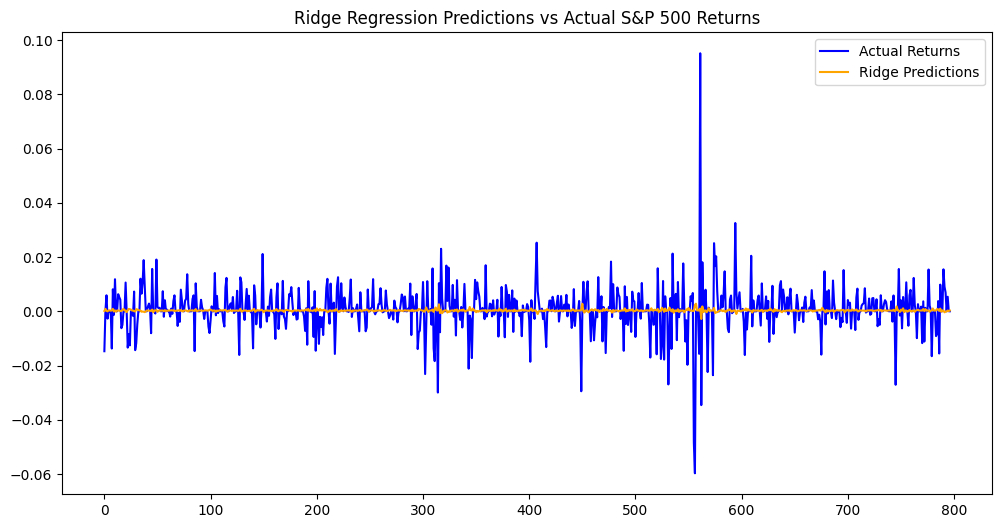

In [69]:
plt.figure(figsize = (12, 6))

plt.plot(y_test.values, label = "Actual Returns", color='blue')
plt.plot(y_ridge_pred, label = "Ridge Predictions", color='orange')
plt.title("Ridge Regression Predictions vs Actual S&P 500 Returns")
plt.legend()
plt.show()

**Inflation Protection Analysis**

In [70]:
# Compute real returns

master_df["bitcoin_real_return"] = master_df["bitcoin_close_return"] - master_df["cpiaucsl_change"]
master_df["sp500_real_return"] = master_df["sp500_close_return"] - master_df["cpiaucsl_change"]
master_df["gold_real_return"] = master_df["gold_close_return"] - master_df["cpiaucsl_change"]
master_df["usdx_real_return"] = master_df["usdx_close_return"] - master_df["cpiaucsl_change"]



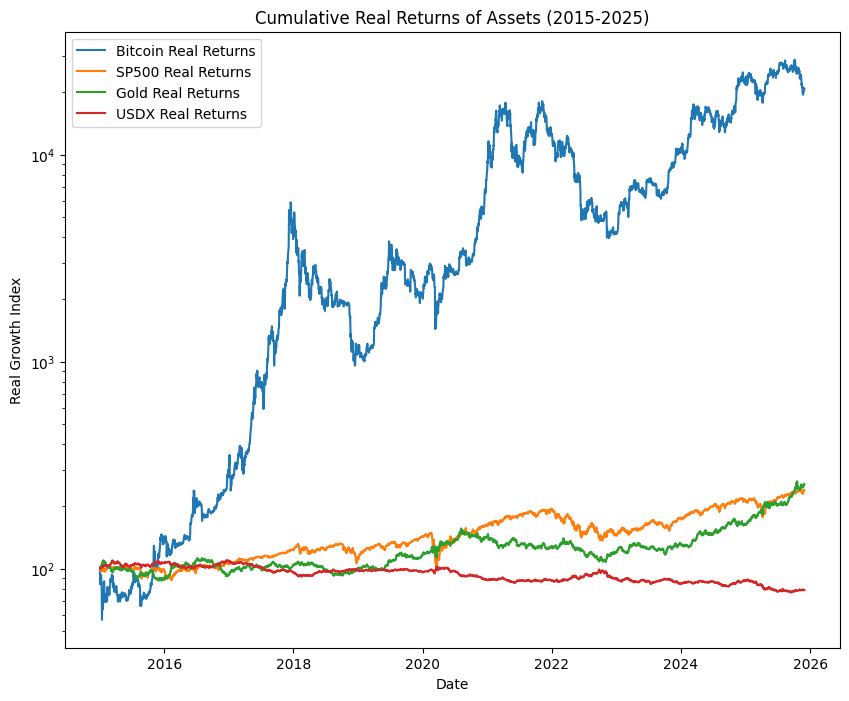

In [ ]:
# Cummulative real growth

bitcoin_real_cum = (1 + master_df["bitcoin_real_return"]).cumprod() * 100
sp500_real_cum = (1 + master_df["sp500_real_return"]).cumprod() * 100
gold_real_cum = (1 + master_df["gold_real_return"]).cumprod() * 100
usdx_real_cum = (1 + master_df["usdx_real_return"]).cumprod() * 100

# Plot cummulative real growth

plt.figure(figsize = (10, 8))

plt.plot(bitcoin_real_cum, label = "Bitcoin Real Returns")
plt.plot(sp500_real_cum, label = "SP500 Real Returns")
plt.plot(gold_real_cum, label = "Gold Real Returns")
plt.plot(usdx_real_cum, label = "USDX Real Returns")

plt.xlabel("Date")
plt.ylabel("Real Growth Index")
plt.yscale("log")
plt.title("Cumulative Real Returns of Assets (2015-2025)")
plt.legend()
plt.show()

## Step 11 — Final Insight Synthesis

### 11.1 Safe Haven Performance
- Gold exhibited the smallest drawdowns during crisis periods
- USDX remained stable but showed limited upside
- Bitcoin experienced deep drawdowns, indicating speculative behavior

### 11.2 Growth Evaluation
- Bitcoin achieved the highest long-term growth and Sharpe ratio
- S&P 500 provided steady compounding
- Gold preserved value but underperformed risk assets

### 11.3 Inflation Protection
- Bitcoin and S&P 500 outpaced CPI over the long run
- Gold maintained purchasing power
- USDX showed weak inflation protection

### 11.4 Trade-offs
- No single asset dominates all dimensions
- Safe haven assets sacrifice growth
- Growth assets expose investors to drawdowns


### Normalized Asset Growth

In [84]:
master_df.head()

,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume,gold_close,gold_high,gold_low,gold_open,gold_volume,...,gold_close_return,bitcoin_close_return,usdx_close_return,vixcls_change,cpiaucsl_change,target_sp500,bitcoin_real_return,sp500_real_return,gold_real_return,usdx_real_return
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,NaN,0.002492,NaN,NaN,0.0,0.000000,0.002492,NaN,NaN,NaN
2015-01-03,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,0.000000,-0.107767,0.000000,0.000000,0.0,0.000000,-0.107767,0.000000,0.000000,0.000000
2015-01-04,2058.199951,2072.360107,2046.040039,2058.899902,2.708700e+09,1186.000000,1194.500000,1169.500000,1184.000000,138.0,...,0.000000,-0.060079,0.000000,0.000000,0.0,-0.018278,-0.060079,0.000000,0.000000,0.000000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3.799120e+09,1203.900024,1206.900024,1180.099976,1180.300049,470.0,...,0.015093,0.038907,0.003294,0.119730,0.0,-0.008893,0.038907,-0.018278,0.015093,0.003294
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4.460110e+09,1219.300049,1220.000000,1203.500000,1203.500000,97.0,...,0.012792,0.042682,0.001313,0.060241,0.0,0.011630,0.042682,-0.008893,0.012792,0.001313


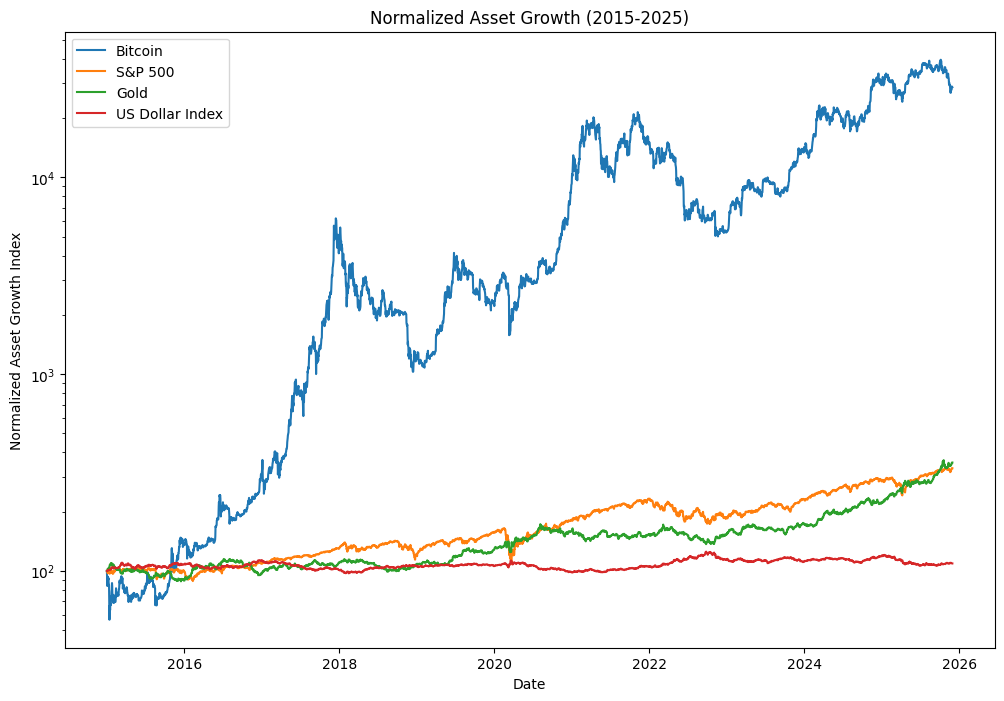

In [88]:
plt.figure(figsize=(12, 8))

plt.plot(bitcoin_norm, label = "Bitcoin")
plt.plot(sp500_norm, label = "S&P 500")
plt.plot(gold_norm, label = "Gold")
plt.plot(usdx_norm, label = "US Dollar Index")

plt.xlabel("Date")
plt.ylabel("Normalized Asset Growth Index")
plt.yscale("log")   
plt.title("Normalized Asset Growth (2015-2025)")

plt.legend()
plt.show()

### Drawdown Curves

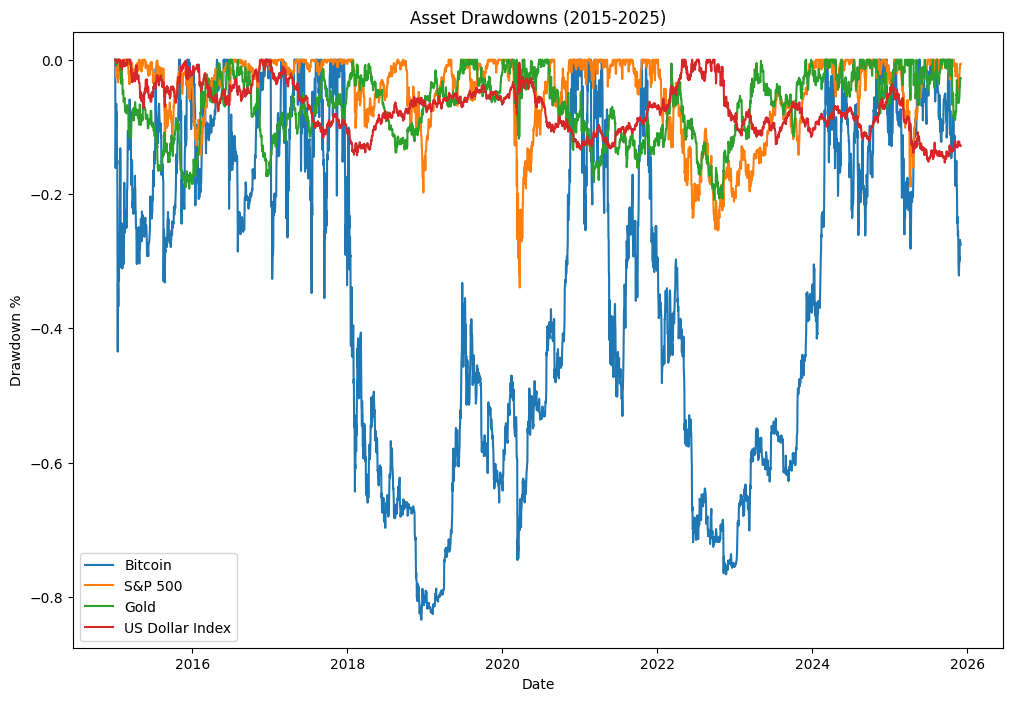

In [91]:
plt.figure(figsize=(12, 8))
plt.plot(bitcoin_drawdown, label = "Bitcoin")
plt.plot(sp500_drawdown, label = "S&P 500")
plt.plot(gold_drawdown, label = "Gold")
plt.plot(usdx_drawdown, label = "US Dollar Index")

plt.title("Asset Drawdowns (2015-2025)")
plt.ylabel("Drawdown %")
plt.xlabel("Date")


plt.legend()
plt.show()